In [1]:
from IPython.display import Markdown
Markdown(filename='README.md')

# Estimate of Public Jupyter Notebooks on GitHub

- [View the daily report notebook](https://github.com/parente/nbestimate/blob/master/estimate.ipynb)
- [See the raw count data in a CSV](https://github.com/parente/nbestimate/blob/master/ipynb_counts.csv)

## Data Collection History

- Late-2014 to mid-2016: I wrote a script that scrapes the GitHub web search UI for the count,
  appends to a CSV, executes a notebook, and stores the results in a gist at
  https://gist.github.com/parente/facb555dfbae28e817e0. I scheduled the script to run daily.
- Mid-2106 to Late-2016: The GitHub web search UI started requiring authentication to see global
  search results. I stopped collecting data.
- Late-2016 to early-2019: I rewrote the process to include a human-in-the-loop who entered the hit
  count after viewing the search results page. I moved the CSV, notebook, and scripts to this repo,
  and sporadically ran the script.
- Early-2019: I found out that the GitHub search API now supports global search. I automated the
  entire collection process again and set it to run on TravisCI on a daily schedule.
- December 2020: [GitHub changed their code search index results](https://github.blog/changelog/2020-12-17-changes-to-code-search-indexing/)
  to exclude repositories without activity for the past year. The ipynb search result count
  dropped from nearly 10 million to 4.5 million `ipynb` files, stayed there for a day or so, and
  then began climbing again from that new origin.
- June 2021: I started collecting data again but disabled the notebook showing the historical and
  predicted counts.
- July 2021: I revived the notebook showing the historical counts but kept prediction disabled.
- April 2023: I noticed that after reporting an all time high of 11 million search results on
  2023-04-19, the GitHub code search API started returning orders of magnitude fewer results in the
  following days (1M, 100k, 1k). In contrast, the GitHub search UI reports 3.4M hits for the same
  query, which is still a far cry from the 11M reported by the API previously.

## Assumptions

- That the search query hits are less than or equal to the total number of `*.ipynb` files on GitHub.
- That the result is **not** inflated due to GitHub forks.
  - Evidence: We do not see the tutorial notebooks from the ipython/ipython GitHub repository
    duplicated in the search results because of the 2,000+ forks of the ipython/ipython repo.
- That the result **is** inflated a tiny bit by manually created duplicates of notebooks.
  - Evidence: Some people seem to download their favorite notebooks and then upload them into
    their own git repositories for safe keeping.


In [2]:
%matplotlib inline

In [3]:
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests

In [4]:
mpl.style.use('ggplot')
figsize = (14,7)

In [5]:
now = datetime.datetime.utcnow()
print(f'This notebook was last rendered at {now} UTC')

This notebook was last rendered at 2023-10-21 05:08:04.466027 UTC


First, let's load the historical data into a DataFrame indexed by date.

In [6]:
hits_df = pd.read_csv('ipynb_counts.csv', index_col=0, header=0, parse_dates=True)
hits_df.reset_index(inplace=True)
hits_df.drop_duplicates(subset='date', inplace=True)
hits_df.set_index('date', inplace=True)
hits_df.sort_index(ascending=True, inplace=True)

In [7]:
hits_df.tail(3)

,hits
date,
2023-10-19,1560
2023-10-20,2368
2023-10-21,3592


There might be missing counts for days that we failed to sample. We build up the expected date range and insert NaNs for dates we missed.

In [8]:
til_today = pd.date_range(hits_df.index[0], hits_df.index[-1])

In [9]:
hits_df = hits_df.reindex(til_today)

Now we plot the known notebook counts.

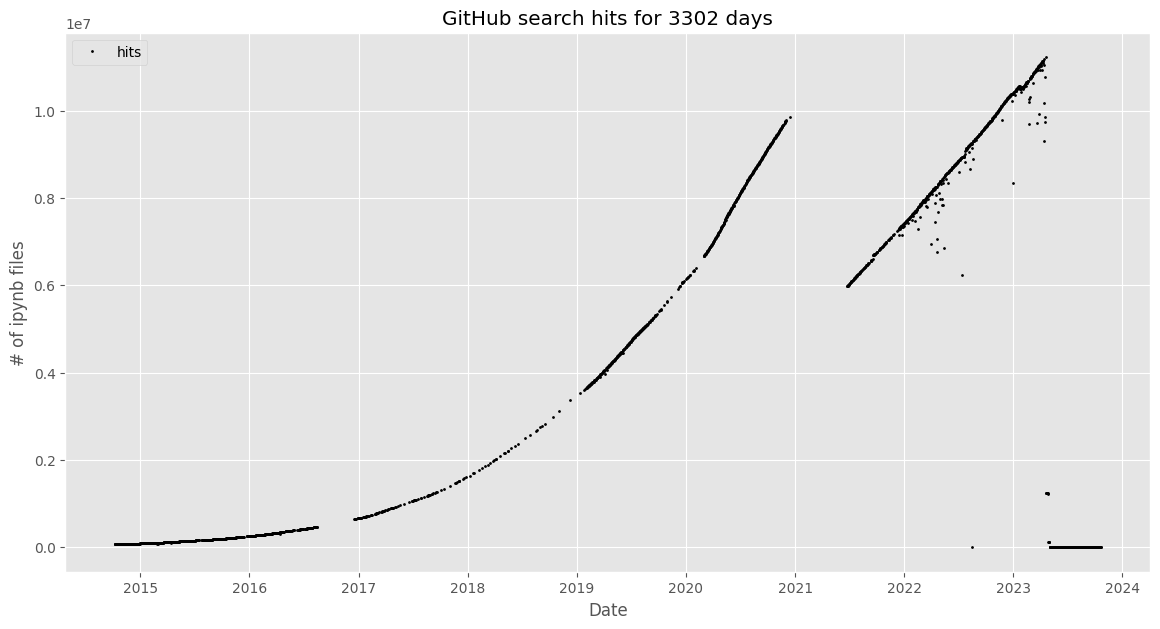

In [10]:
fig, ax = plt.subplots(figsize=figsize)
ax.set_title(f'GitHub search hits for {len(hits_df)} days')
ax.plot(hits_df.hits, 'ko', markersize=1, label='hits')
ax.legend(loc='upper left')
ax.set_xlabel('Date')
ax.set_ylabel('# of ipynb files');

Growth appears exponential until December 2020, at which point the count dropped suddenly and resumed growth from a new origin.

The total change in the number of `*.ipynb` hits between the first day we have data and today is:

In [11]:
total_delta_nbs = hits_df.iloc[-1] - hits_df.iloc[0]
total_delta_nbs

hits   -62256.0
dtype: float64

The mean daily change for the entire duration is:

In [12]:
avg_delta_nbs = total_delta_nbs / len(hits_df)
avg_delta_nbs

hits   -18.854028
dtype: float64

The change in hit count between any two consecutive days for which we have data looks like the following:

In [13]:
daily_deltas = (hits_df.hits - hits_df.hits.shift())

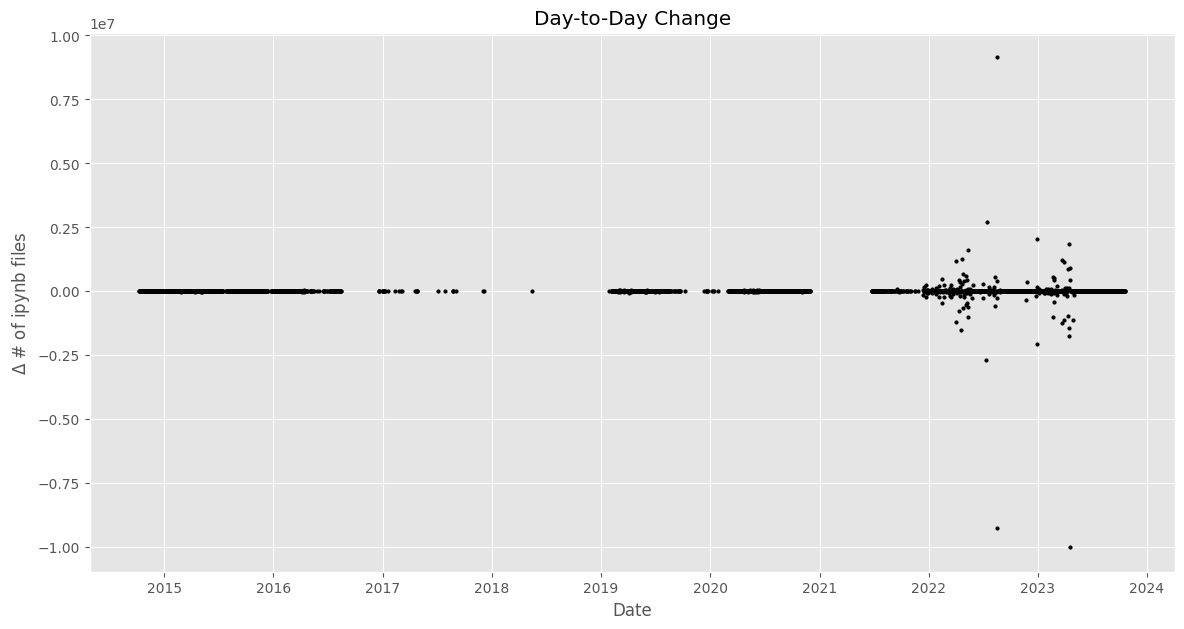

In [14]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(daily_deltas, 'ko', markersize=2)
ax.set_xlabel('Date')
ax.set_ylabel('$\Delta$ # of ipynb files')
ax.set_title('Day-to-Day Change');

The large jumps in the data are from GitHub reporting drastically different counts from one day to the next.

Let's drop outliers defined as values more than two standard deviations away from a centered 90 day rolling mean.

In [15]:
daily_delta_rolling = daily_deltas.rolling(window=90, min_periods=0, center=True)
outliers = abs(daily_deltas - daily_delta_rolling.mean()) > 2*daily_delta_rolling.std()
outliers.value_counts()

hits
False    3222
True       80
Name: count, dtype: int64

In [16]:
cleaned_hits_df = hits_df.copy()
cleaned_hits_df[outliers] = np.NaN
cleaned_daily_deltas = (cleaned_hits_df.hits - cleaned_hits_df.hits.shift())

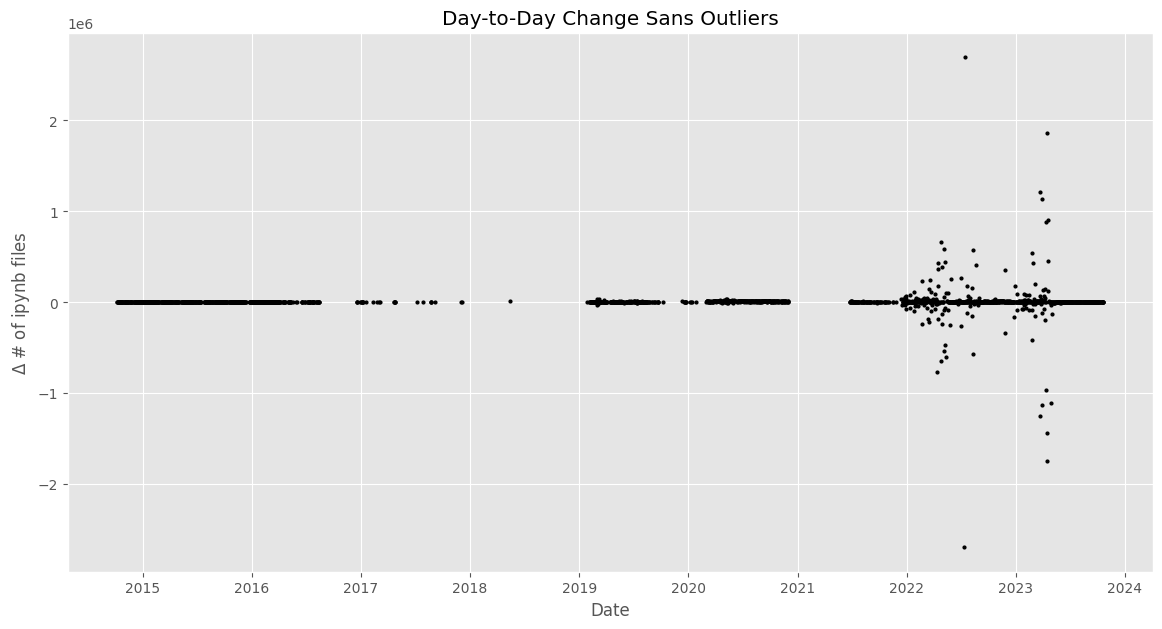

In [17]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(cleaned_daily_deltas, 'ko', markersize=2)
ax.set_xlabel('Date')
ax.set_ylabel('$\Delta$ # of ipynb files')
ax.set_title('Day-to-Day Change Sans Outliers');